In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import random
import copy
import time
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D

<h3>Assumptions</h3>
<ul>
    <li>Travel speed is consistent with all drivers</li>
    <li>Job duration is how long the engineer will be on the job site</li>
    <li>Engineers start at a base location but can travel between job sites to complete multiple jobs in a day</li>
    <li>If jobs are not completed when the day end, the next day will continue with the engineers starting from their base locations</li>
    <li>Each job length is a mimimum of 30 minutes and a maximum of 3 hours</li>
    <li>When a job is scheduled, that involves the time a engineer leaves for a job</li>
    <li>It's preferable for jobs to be completed in the shortest number of days</li>
</ul>

In [165]:
N_ENGINEERS = 4
N_JOBS = 30
MIN_TIME = 9
MAX_TIME = 17
MAP_SIZE = 25
MIN_DUR = 0.5
MAX_DUR = 3
SPEED = 60 #KMH

In [169]:
job_sites = np.random.randint(low=0, high=MAP_SIZE, size =(N_JOBS,2))
job_lengths = (np.random.ranf(size =(N_JOBS))*(MAX_DUR-MIN_DUR))+MIN_DUR
engineer_base = np.random.randint(low=0, high=MAP_SIZE, size =(N_ENGINEERS,2))
sites_df = pd.DataFrame(job_sites, columns=["x","y"])
engineers_df = pd.DataFrame(engineer_base, columns=["x","y"])

In [170]:
jobs_and_durations = pd.DataFrame(job_sites, columns=["x-coord","y-coord"])
jobs_and_durations["Duration in hours"] = job_lengths
jobs_and_durations.head()

,x-coord,y-coord,Duration in hours
0,1,12,2.868534
1,16,1,1.157267
2,12,11,1.610308
3,22,5,1.910791
4,15,6,0.617076


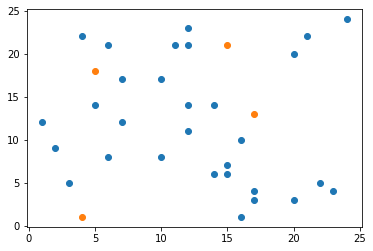

In [171]:
plt.scatter(sites_df.x,sites_df.y)
plt.scatter(engineers_df.x,engineers_df.y)

In [172]:
class Agent:
    def __init__(self):
        #Randomise the job indexs
        self.jobs = [x for x in range(N_JOBS)]
        random.shuffle(self.jobs)
        
        self.create_routes()
        self.utility()
        
    def mutate(self, n):
        for x in range(n):
            valid = False

            while not valid:
                temp_jobs = self.jobs.copy()
                temp_cuts = self.cuts.copy()
                #Job position swap
                pos1 = random.randint(0,len(temp_jobs)-1)
                pos2 = random.randint(0,len(temp_jobs)-1)
                while pos2 == pos1:
                    pos2 = random.randint(0,len(temp_jobs)-1)

                temp_jobs[pos1], temp_jobs[pos2] = temp_jobs[pos2], temp_jobs[pos1]

                #Job cut mutate
                choice = random.randint(0,3)
                cut_index = random.randint(0,len(temp_cuts)-1)
                #Move cut up or down
                if choice == 0:
                    if temp_cuts[cut_index] == 0:
                        temp_cuts[cut_index]+=1
                    elif temp_cuts[cut_index] == len(temp_cuts):
                        temp_cuts[cut_index]-=1
                    else:
                        temp_cuts[cut_index]+=random.choice([1,-1])
                #Remove cut
                elif choice == 1:
                    if len(temp_cuts)>1:
                        temp_cuts.pop(cut_index)
                #Add cut
                elif choice == 2:
                    temp_cuts.insert(cut_index, temp_cuts[cut_index])

                temp_cuts.sort()
                valid = self.create_new_routes(temp_cuts, temp_jobs)

            self.jobs = temp_jobs.copy()
            self.cuts = temp_cuts.copy()
            self.utility()
        
    def create_new_routes(self, cuts, jobs):
        #Engineer routes in a day
        days = []
        #Engineers routes
        engineers = []
        
        start = 0
        #Gives each engineer their jobs
        for n, cut in enumerate(cuts):
            
            if n == len(cuts)-1:
                cut = None
                
            engineers.append(jobs[start:cut])
            start = cut
            #Start a new day if all engineers are occupied
            if len(engineers) == N_ENGINEERS:
                days.append(engineers.copy())
                engineers = []
                
        days.append(engineers.copy())
        
        valid = self.valid_solution(days)
        
        if valid:
            self.days = days.copy()
            return True
        else:
            return False
        
    def valid_solution(self, days):
        valid = True
        for day in days:
            if not valid:
                break
            for idx, engineer in enumerate(day):
                if len(engineer)>1:
                    if self.available(idx, engineer[0:-2]) is False:
                        valid = False
        return valid
        
    def create_routes(self):
        #Engineer routes in a day
        self.days = []
        #Engineers routes
        engineers = [[] for x in range(N_ENGINEERS)]
        
        idx = 0
        for x in range(N_JOBS):
            failure = True
            while failure:
                
                if not self.available(idx, engineers[idx]):
                    idx+=1
                    if idx == N_ENGINEERS:
                        self.days.append(engineers.copy())
                        idx = 0
                        engineers = [[] for x in range(N_ENGINEERS)]
                else:         
                    engineers[idx].append(self.jobs[x])
                    failure = False
        
        self.days.append(engineers)
        self.get_cuts()
        #Get index cuts of jobs
    def get_cuts(self):
        self.cuts = []
        idx_cutoff = 0
        for day in self.days:
            for engineer in day:
                idx_cutoff += len(engineer)
                self.cuts.append(idx_cutoff)
        
        self.cuts.pop(-1)
            
    def available(self, eng_idx, route):
        
        available = True
        
        t = MIN_TIME
        #Get engineer base location with engineer index
        start = [engineers_df.iloc[eng_idx].x,engineers_df.iloc[eng_idx].y]
        
        engineer_route = route
        
        for x in range(len(engineer_route)):
            #Get index of next job site to travel to
            loc_idx = engineer_route[x]
            #Get location of that job ite
            end = [sites_df.iloc[loc_idx].x,sites_df.iloc[loc_idx].y]
            
            #Find time to travel to job site (d/t) and do job then add to score
            t+= self.distance(start, end)/SPEED + job_lengths[loc_idx]
            
            #new location is current one, loop till last location is reached
            start = end.copy()
        
        if t > MAX_TIME:
            available = False
            
        return available
    
    #Distance between job sites
    def distance(self, l1, l2):
        return ((l1[0]-l2[0])**2+(l1[1]-l2[1])**2)**0.5
    
    def utility(self):
        self.score = 0
        #Plot route of reach day
        for day in self.days:
            self.score += 1
            #Map out each engineers route
            for i, route in enumerate(day):
                start = [engineers_df.iloc[i].x,engineers_df.iloc[i].y]

                for x in route:
                    end = [sites_df.iloc[x].x,sites_df.iloc[x].y]
                    
                    self.score += self.distance(start,end)/SPEED

                    start = end.copy()
    
    #Visuslise the routes
    def visualise(self):
        #Plot route of reach dayplt subplots
        colors = ["#%06x" % random.randint(0, 0xFFFFFF) for x in range(N_ENGINEERS)]
        custom_lines = []
        for col in colors:
            custom_lines.append(Line2D([0], [0], color=col, lw=4))
        fig, axs = plt.subplots(1,len(self.days), figsize=(20,10))
        fig.legend()
        for n, day in enumerate(self.days):
            axs[n].set_title("Day "+str(n+1))
            #plot the locations of engineer bases and job sites
            axs[n].scatter(sites_df.x,sites_df.y)
            axs[n].scatter(engineers_df.x,engineers_df.y)

            #Map out each engineers route
            for i, route in enumerate(day):
                start = [engineers_df.iloc[i].x,engineers_df.iloc[i].y]

                for x in route:
                    end = [sites_df.iloc[x].x,sites_df.iloc[x].y]

                    x = [start[0],end[0]]
                    y = [start[1],end[1]]
                    
                    axs[n].plot(x,y, color=colors[i], label="Engineer "+str(i+1))
                    start = end.copy()

                axs[n].legend(custom_lines, ["Engineer "+str(x+1) for x in range(N_ENGINEERS)])
    
    def local_avg_utility(self,engineer, route):
        score = 0
        start = [engineers_df.iloc[engineer].x,engineers_df.iloc[engineer].y]
        
        for x in route:
            end = [sites_df.iloc[x].x,sites_df.iloc[x].y]

            score += self.distance(start,end)/SPEED

            start = end.copy()
        
        return score/len(route)
                
    def recombination(self, partner_agent):
        #score each engineers route
        scores, routes, engineers = [], [], []

        for parent in (self, partner_agent):
            #Plot route of reach day
            for day in parent.days:
                #Map out each engineers route
                for i, route in enumerate(day):
                    if len(route)!=0:
                        score = self.local_avg_utility(i, route)
                        scores.append(score)

                        routes.append(route.copy())
                        engineers.append(i)

        #sort rotues by score
        zipped = zip(scores,routes,engineers)
        zipped = sorted(zipped, key=lambda x: x[0])
        zipped = list(zipped)

        #Pick new routes
        job_list = self.jobs.copy()
        new_routes = []
        engineers = []
        for (score,route,engineer) in zipped:
            possible = True
            
            #Make sure that one engineer is prioristed
            unique_values = []
            for eng in range(4):
                unique_values.append(engineers.count(eng))
            if unique_values[engineer] <= min(unique_values)+1:
                
                #Check that the entire route is available
                for r in route:
                    if r not in job_list:
                        possible = False
                        break

                if possible:
                    new_routes.append(route)
                    engineers.append(engineer)
                    
                    for r in route:
                        job_list.remove(r)

        #If there are remaining places not gone to, check to see if they can be placed into other routes
        if len(job_list) != 0:
            for i, route in enumerate(new_routes):
                #Check if route can include an additional job
                if self.available(engineers[i], route):
                    best_score = self.local_avg_utility(engineers[i], route)
                    best_route = route.copy()
                    best_job = None
                    
                    for j in job_list:
                        for x in range(len(route)+1):
                            test_route = route.copy()
                            test_route.insert(x, j)
                            test_score = self.local_avg_utility(engineers[i], test_route)
                            
                            if test_score <= best_score:
                                best_score = test_score
                                best_route = test_route.copy()
                                best_job = j

                    if best_job is not None:
                        new_routes[i] = best_route.copy()
                        job_list.remove(best_job)      
        #Create new routes with the remaining unvisited locations
        while True:
            if len(job_list) != 0:
                unique_values = []
                for eng in range(4):
                     unique_values.append(engineers.count(eng))
                eng_idx = unique_values.index(min(unique_values))
                
                for y in range(len(job_list)):
                    if not self.available(eng_idx, job_list[0:y+1]):
                        new_routes.append(job_list[0:y].copy())
                        engineers.append(eng_idx)
                        
                        for x in new_routes[-1]:
                            job_list.remove(x)
                        break
                    elif y+1 == len(job_list):
                        new_routes.append(job_list.copy())
                        engineers.append(eng_idx)
                        job_list.clear()
                        break
            else:
                break
        #Reformat the results
        temp_jobs = []
        temp_cuts = []
        
        eng_idx = 0
        for x in range(len(new_routes)):
            
            while True:

                if eng_idx in engineers:

                    idx = engineers.index(eng_idx)
                    route = new_routes[idx].copy()
                    for r in route:
                        temp_jobs.append(r)

                    if len(temp_cuts) != 0:
                        temp_cuts.append(temp_cuts[-1]+len(route))
                    else:
                        temp_cuts.append(len(route))

                    new_routes.pop(idx)
                    engineers.pop(idx)

                    eng_idx += 1

                    if eng_idx == 4:
                        eng_idx = 0
                        
                    break

                else:
                    eng_idx+=1

                    if len(temp_cuts) != 0:
                        temp_cuts.append(temp_cuts[-1])
                    else:
                        temp_cuts.append(0)

                    if eng_idx == 4:
                        eng_idx = 0
                        
        valid = self.create_new_routes(temp_cuts, temp_jobs)
        self.jobs = temp_jobs.copy()
        self.cuts = temp_cuts.copy()
        self.utility()

In [173]:
t = time.time()
N_EPISODES = 1000
n_agents = 20
agent_scores = []

#Create population
agents = [Agent() for x in range(n_agents)]

#Loop through each episode
for e in range(N_EPISODES):
    if (e+1)%50 == 0:
        print(e+1)
    #Create a clone of each agent and complete recombination and mutation
    for i in range(n_agents):
        clone = copy.deepcopy(agents[i])
        clone.recombination(random.choice(agents))
        clone.mutate(1)

        agents.append(clone)
    
    #Sort the agents by utility
    agents.sort(key=lambda x: x.score)
    
    #Select the best agents for next episode
    agents = agents[:n_agents]
    
    #Record the current best score
    agent_scores.append(agents[0].score)

print(time.time()-t)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
737.276129245758


No handles with labels found to put in legend.


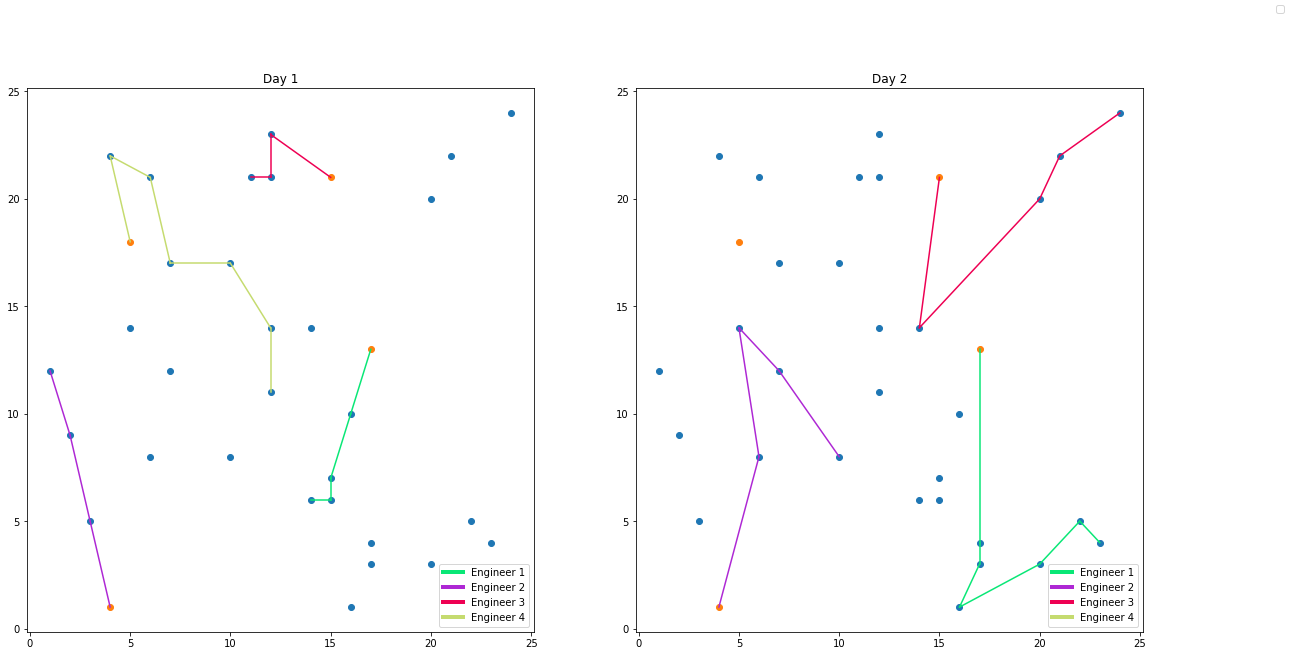

In [174]:
agents[0].visualise()

In [175]:
agents[0].days

[[[23, 22, 4, 27], [7, 11, 0], [18, 16, 29], [24, 10, 9, 26, 25, 2]],
 [[5, 6, 1, 21, 3, 15], [12, 28, 17, 13], [14, 19, 20, 8]]]

In [176]:
agents[0].cuts

[4, 7, 10, 16, 22, 26, 30]

In [177]:
agents[0].score

3.8327756435735827

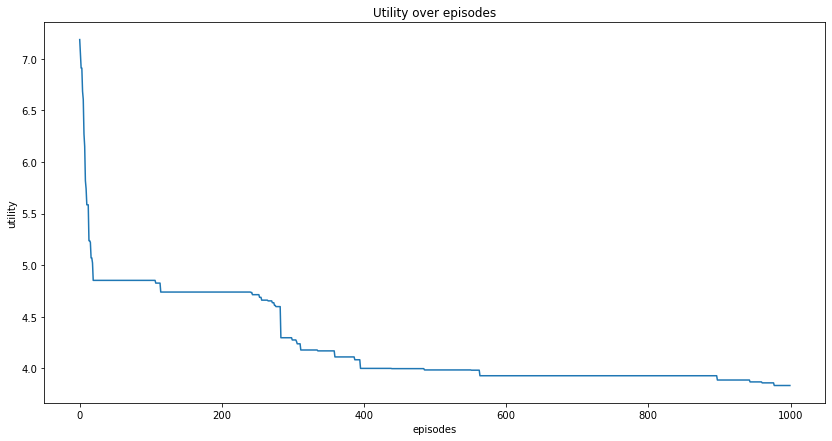

In [186]:
plt.figure(figsize=(14,7))
plt.xlabel('episodes')
plt.ylabel('utility') 
plt.title("Utility over episodes")
plt.plot(agent_scores)

In [154]:
agents[0].jobs

[16,
 17,
 27,
 11,
 18,
 38,
 25,
 3,
 1,
 7,
 22,
 30,
 19,
 29,
 13,
 6,
 21,
 20,
 8,
 32,
 35,
 0,
 31,
 39,
 24,
 2,
 14,
 34,
 5,
 23,
 12,
 37,
 9,
 10,
 15,
 28,
 36,
 33,
 26,
 4]

In [33]:
job_lengths

array([0.85005182, 1.82676889, 2.43028394, 1.02173098, 2.73946551,
       3.18804136, 2.14154728, 2.82120046, 2.42958527, 1.84228265,
       1.37072609, 1.12893799, 1.74828908, 4.1836377 , 4.16594455,
       2.28519982, 4.03545118, 0.63914616, 2.76036346, 0.94013127,
       0.59728853, 3.15422502, 2.01753791, 2.3543901 , 1.26407903,
       1.19889642, 3.49584595, 4.23001233, 1.41562782, 1.10423086,
       4.46864637, 3.48570899, 0.68746468, 3.90258049, 1.2451186 ,
       3.65577205, 3.78761602, 2.94674675, 1.55296866, 2.96552499])